In [1]:
from IPython.display import display, Math,Markdown, Audio

In [2]:
from utils import *

In [3]:
EPS=1e-8

In [4]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams["figure.facecolor"] = "white"

In [5]:
def cardanoSolve(a,b,c,d):
    A = (c-b**2/3/a)/a
    B=(b*c/3/a-2*b**3/27/a**2-d)/a
    S3 = (B+(B**2+4*A**3/27)**(1/2))/2
    S = S3**(1/3)*np.array([1,np.exp(2j*np.pi/3),np.exp(4j*np.pi/3)])
    x = -b/3/a + S - A/3/S
    return x

In [6]:
def poly4(a,b,c,d):
    return lambda x: a*x**3+b*x**2+c*x+d

In [7]:
def polyOmega(g0,ka,b,o0):
    return poly4(1,-(ka+1j*b),g0*ka+o0**2+1j*b*ka,-ka*o0**2)

In [8]:
def rootsPolyOmega(g0,ka,b,o0):
    return cardanoSolve(1,-(ka+1j*b),g0*ka+o0**2+1j*b*ka,-ka*o0**2)

In [9]:
def SNRestimate(array):
    return abs(np.mean(array))/np.std(array)

In [10]:
pool = Pool(4)

In [11]:
g0_hat=0.1
o0_hat=0.02
g0 = 100
ka = g0 /g0_hat;
o0 = ka * o0_hat
b = 1

In [12]:
R,S,H,_ = get_RSH_harmonic_onlyka(o0,g0,b,ka)
SNR_omega = abs(H)/np.sqrt(R*S-H)
roots = rootsPolyOmega(g0,ka,b,o0)+EPS+EPS*1j
print(f"omega: {H/R:0.6f}")
# print(f"{alpha:0.4f}, {beta**2:0.4f}")
print(f"relaxation freq:  ",(np.real(roots)).round(2))
print(f"rotational freq:",(np.imag(roots)).round(2))
print(f"SNR: {SNR_omega:0.4f}")

omega: -0.000400
relaxation freq:   [887.36 108.48   4.15]
rotational freq: [-0.15  1.19 -0.04]
SNR: 0.0000


In [13]:
print(f"g0_hat: {g0/ka:0.3f}  o0_hat: {o0/ka:0.3f}")
display(Markdown(f"b:{b:0.1f}  $\gamma$:{g0:0.1f}  $\kappa$:{ka:0.1f}  $\omega_0$:{o0:0.1f}    "\
f"$2\pi/\langle \omega \\rangle$:{2*np.pi/(H/R+EPS):0.3f}s "\
f"SNR (expected):{SNR_omega:0.3f}  <br>"\
f"root1    relaxation: {1/np.real(roots[0]):0.3f}s     rotation: {1/np.imag(roots[0]):0.3f}s <br>"
f"root2    relaxation: {1/np.real(roots[1]):0.3f}s     rotation: {1/np.imag(roots[1]):0.3f}s <br>"
f"root3    relaxation: {1/np.real(roots[2]):0.3f}s     rotation: {1/np.imag(roots[2]):0.3f}s "))

g0_hat: 0.100  o0_hat: 0.020


b:1.0  $\gamma$:100.0  $\kappa$:1000.0  $\omega_0$:20.0    $2\pi/\langle \omega \rangle$:-15714.639s SNR (expected):0.000  <br>root1    relaxation: 0.001s     rotation: -6.883s <br>root2    relaxation: 0.009s     rotation: 0.840s <br>root3    relaxation: 0.241s     rotation: -22.270s 

In [27]:
N=3000000
warmup=N
dt=0.0001
samples=5
skip=1
runs=4
time = np.linspace(0,N//skip *dt, N//skip)

print(f"memory {(len([1]) * N * runs * samples *4 // skip) * 4 / 1024**3:0.2f}")

memory 0.89


In [28]:
sigma = get_cov(np.array([R]), np.array([S]), np.array([H]))

x0,y0,vx0,vy0 = np.random.multivariate_normal(
    [0,0,0,0], 0*sigma[...,0], samples).T
kwargs = dict(x0=x0,y0=y0,vx0=vx0,vy0=vy0,
    N=N, samples=samples,
    dt=dt, warmup=warmup, skip=skip,
    omega0=o0,
    gamma0=g0,b=b, kappa=ka)
result = simulate_2d_only_memory(pool,runs,**kwargs)

result = np.array(result); result.shape

(6, 20, 3000000)

In [29]:
stationari_treshold = 0

In [30]:
x,y,vx,vy,_,_ = result[:,:,stationari_treshold:][:,:,:]

In [31]:
crosprod=(-x[:,1:]*y[:,:-1] + y[:,1:]*x[:,:-1])/(np.sqrt(x[:,1:]**2+y[:,1:]**2)*np.sqrt(x[:,:-1]**2+y[:,:-1]**2))
phi = np.arcsin(crosprod).cumsum(axis=-1)
del crosprod

In [35]:
start = 0*100
# OMEGA = b
TURNS = 0.0001
OMEGA = OMEGA if abs(H/R)<EPS else abs(H/R)
# OMEGA = 1

# OMEGA = den**0.5
rang = int(2*3.14/OMEGA/dt * TURNS)
path = 1
factor = 2.5
print(x.shape[1],rang, OMEGA)

st=1

3000000 15706 0.00039984006397441024


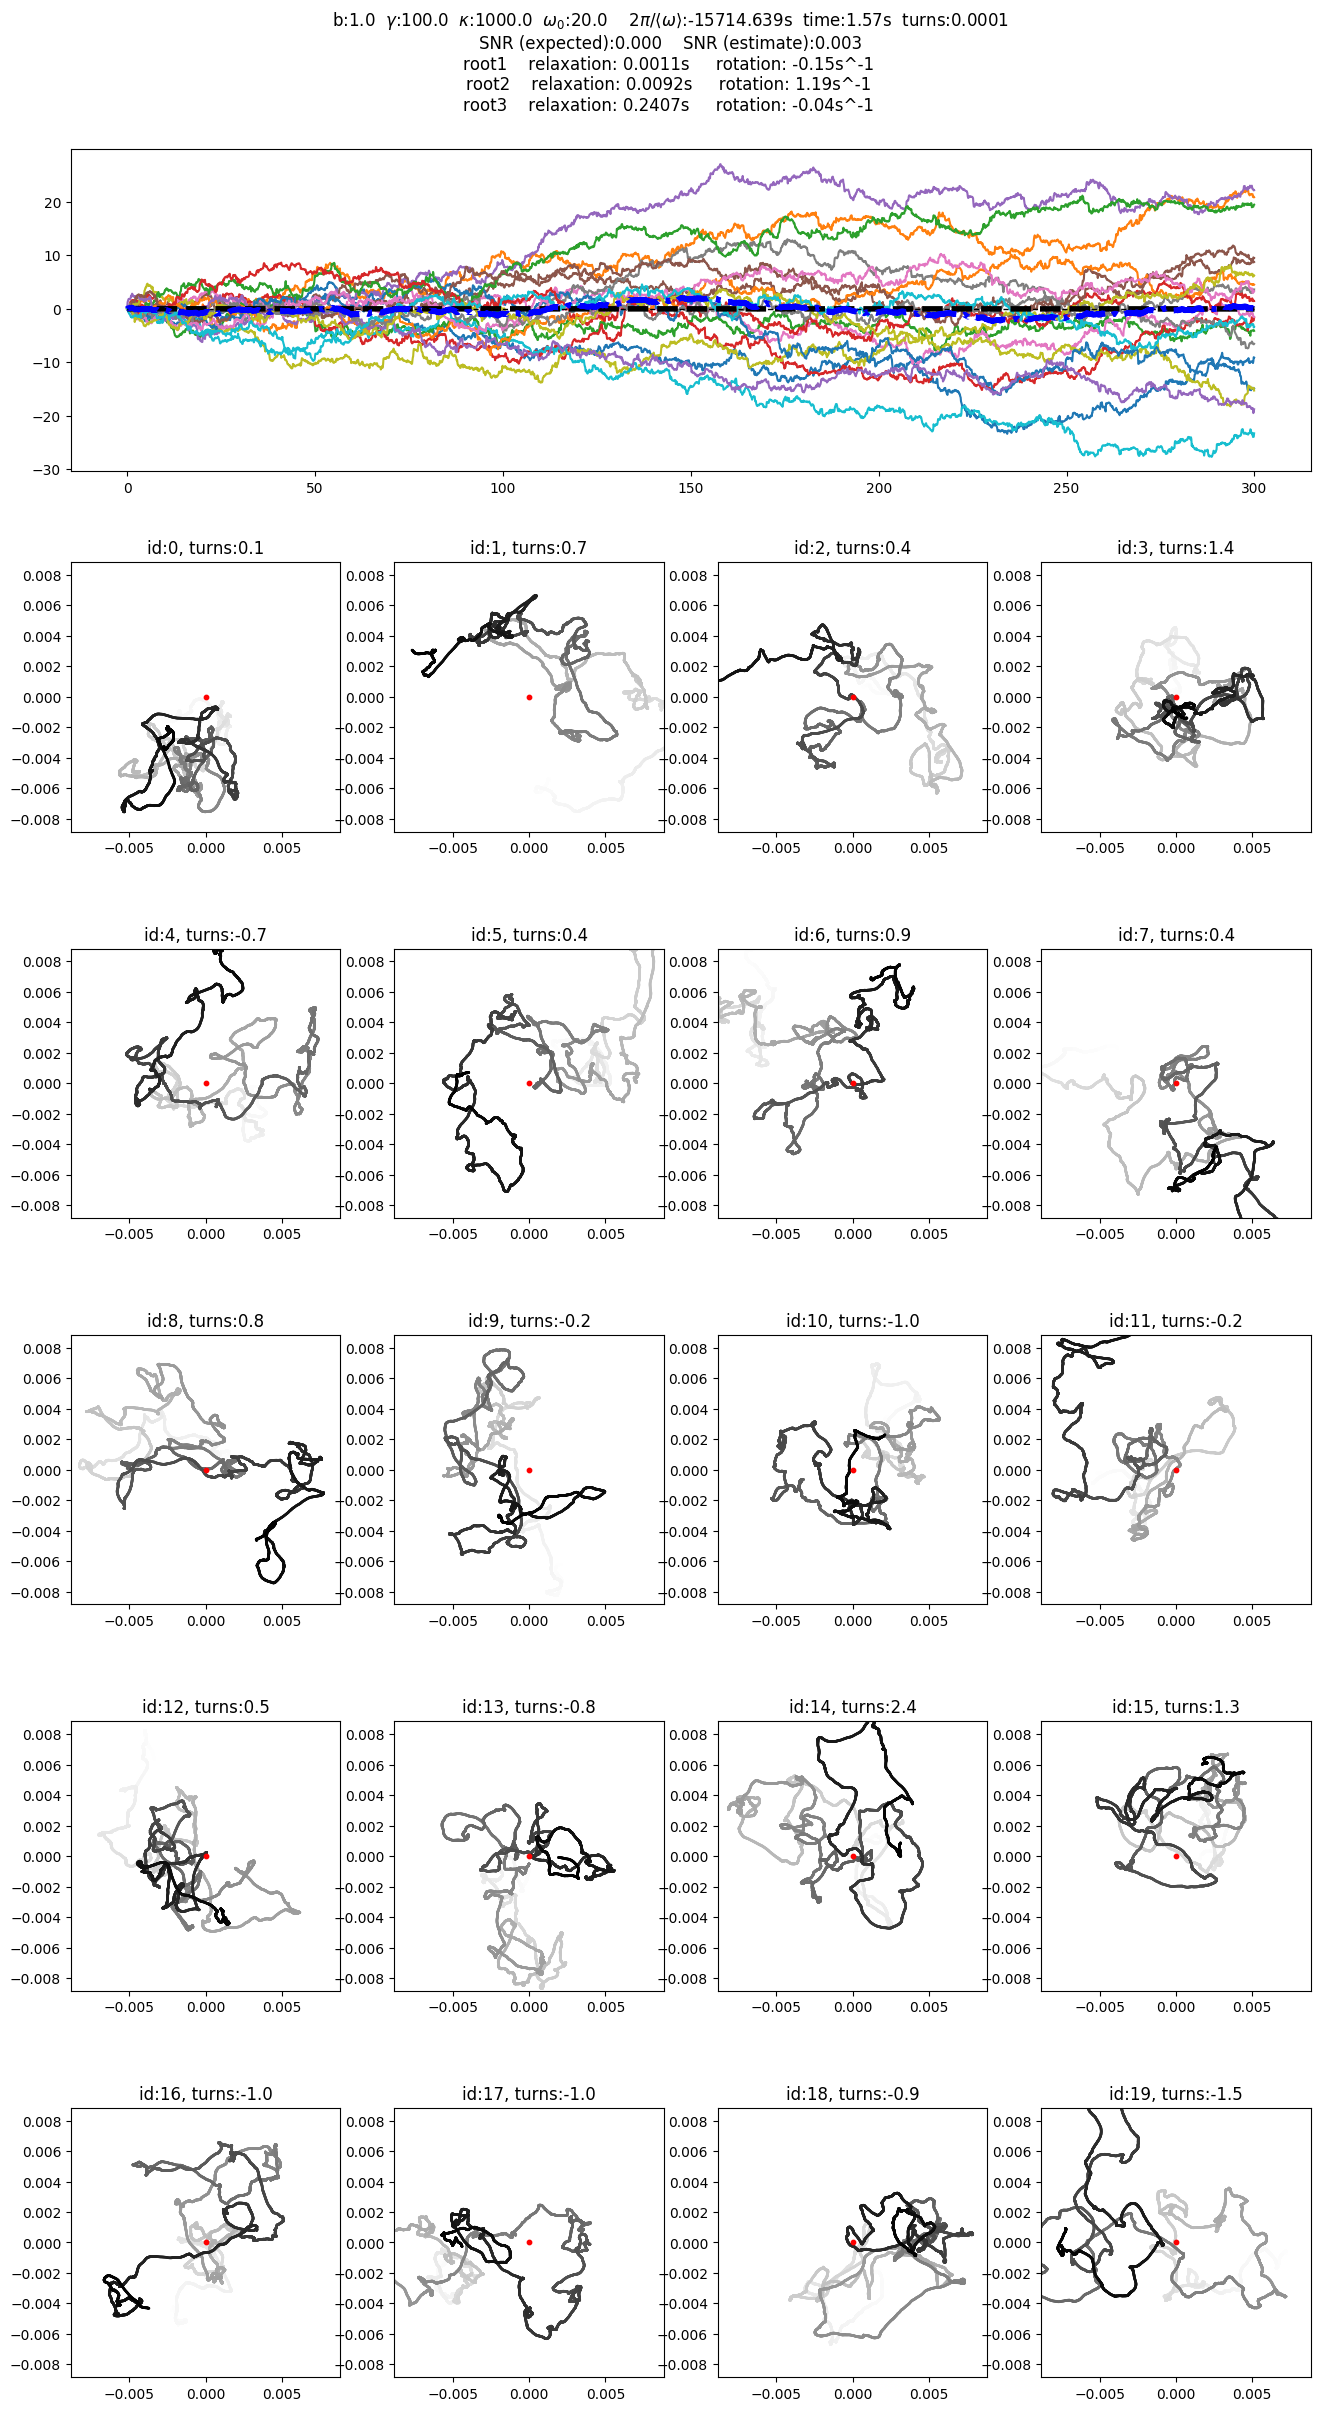

In [43]:
fig = plt.figure(figsize=(16,28), dpi=100)
fig.subplots_adjust(top=0.93)
plt.suptitle(f"b:{b:0.1f}  $\gamma$:{g0:0.1f}  $\kappa$:{ka:0.1f}  $\omega_0$:{o0:0.1f}    "\
f"$2\pi/\langle \omega \\rangle$:{2*np.pi/(H/R+EPS):0.3f}s  time:{2*np.pi/OMEGA*TURNS:0.2f}s  turns:{TURNS}\n"\
f"SNR (expected):{SNR_omega:0.3f}    SNR (estimate):{SNRestimate(phi[:,-1]):0.3f}\n"\
f"root1    relaxation: {1/np.real(roots[0]):0.4f}s     rotation: {np.imag(roots[0]):0.2f}s^-1 \n"
f"root2    relaxation: {1/np.real(roots[1]):0.4f}s     rotation: {np.imag(roots[1]):0.2f}s^-1 \n"
f"root3    relaxation: {1/np.real(roots[2]):0.4f}s     rotation: {np.imag(roots[2]):0.2f}s^-1 ")

plt.subplot(6,1,1)
plt.plot(time[::1000,None],phi[:,::1000].T/2/np.pi);
plt.plot([0, time[-1]], [0,time[-1]*H/R/2/np.pi], c="k", ls="--", lw=4)
plt.plot([0, time[-1]], [0,0], c="k", ls="--", lw=1)

plt.plot(time[::1000],phi[:,::1000].mean(axis=0)/2/np.pi, lw=4, c="b", ls="-.");

N_plots = 20
i_plots = np.arange(N_plots)
for i, path in enumerate(i_plots):
    ax = plt.subplot(1+N_plots//4,4,4+i+1)
    cm = plt.get_cmap("Greys")
    
#     for i in range(rang-1):
#         ax.plot(x[path][start:][i:i+2],y[path][start:][i:i+2],  c=cm(0.2+0.8*i/rang))
    plt.title(f"id:{path}, turns:{(phi[path,start+rang] - phi[path,start])/2/np.pi:0.1f}")
    ax.scatter(x[path][start:][:rang][::st],y[path][start:][:rang][::st], 
               c=-np.linspace(0.4,0.8,rang)[::st], s=0.9, cmap="gray", alpha=0.8)
    ax.scatter([0],[0], c="red", s=10)

    ax.set_aspect("equal")
    ax.set_xlim(-factor*R**0.5,factor*R**0.5)
    ax.set_ylim(-factor*R**0.5,factor*R**0.5)        



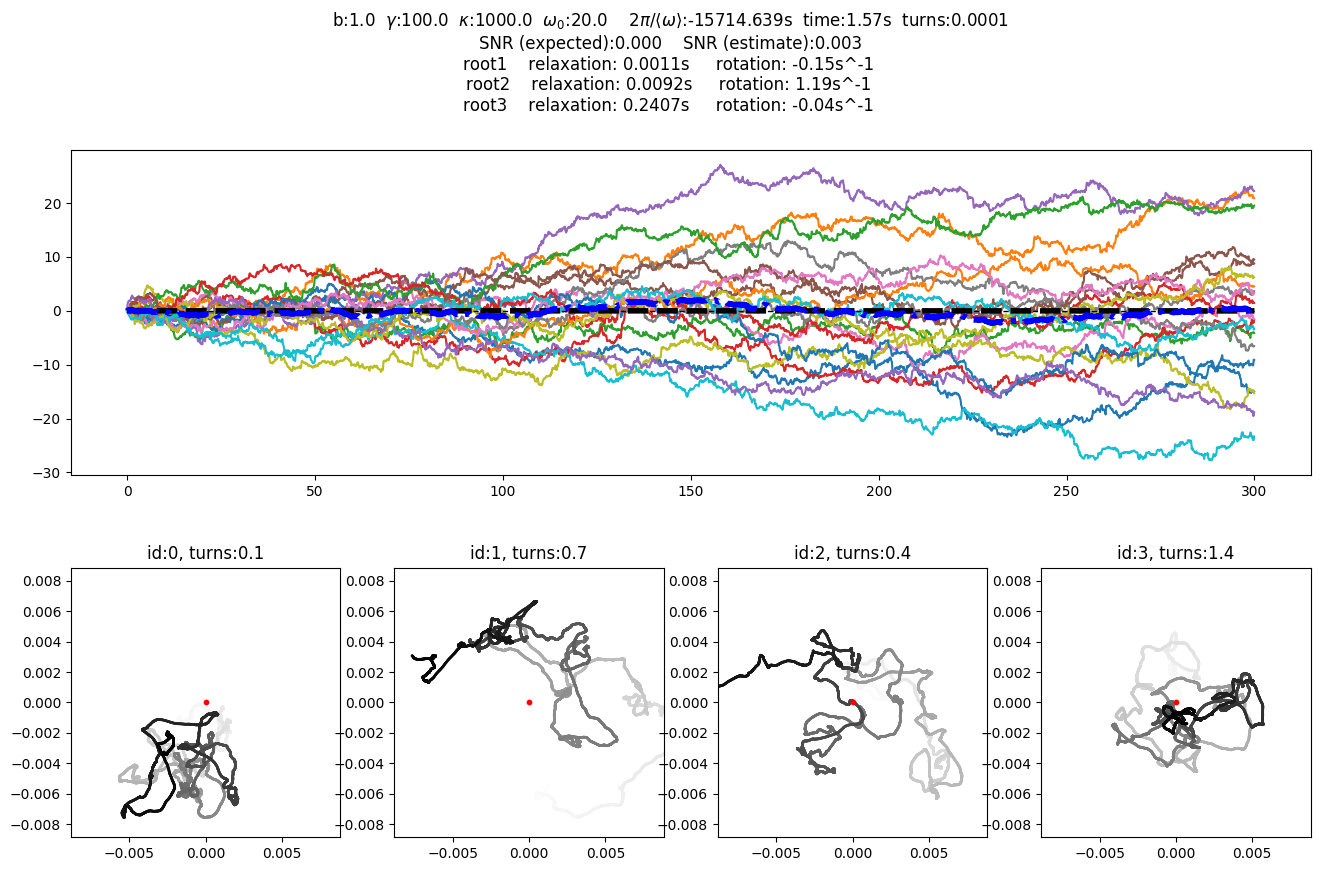

In [48]:
fig = plt.figure(figsize=(16,10), dpi=100)
fig.subplots_adjust(top=0.84)
plt.suptitle(f"b:{b:0.1f}  $\gamma$:{g0:0.1f}  $\kappa$:{ka:0.1f}  $\omega_0$:{o0:0.1f}    "\
f"$2\pi/\langle \omega \\rangle$:{2*np.pi/(H/R+EPS):0.3f}s  time:{2*np.pi/OMEGA*TURNS:0.2f}s  turns:{TURNS}\n"\
f"SNR (expected):{SNR_omega:0.3f}    SNR (estimate):{SNRestimate(phi[:,-1]):0.3f}\n"\
f"root1    relaxation: {1/np.real(roots[0]):0.4f}s     rotation: {np.imag(roots[0]):0.2f}s^-1 \n"
f"root2    relaxation: {1/np.real(roots[1]):0.4f}s     rotation: {np.imag(roots[1]):0.2f}s^-1 \n"
f"root3    relaxation: {1/np.real(roots[2]):0.4f}s     rotation: {np.imag(roots[2]):0.2f}s^-1 ")

plt.subplot(2,1,1)
plt.plot(time[::1000,None],phi[:,::1000].T/2/np.pi);
plt.plot([0, time[-1]], [0,time[-1]*H/R/2/np.pi], c="k", ls="--", lw=4)
plt.plot([0, time[-1]], [0,0], c="k", ls="--", lw=1)

plt.plot(time[::1000],phi[:,::1000].mean(axis=0)/2/np.pi, lw=4, c="b", ls="-.");

N_plots = 4
i_plots = np.arange(N_plots)
for i, path in enumerate(i_plots):
    ax = plt.subplot(2,4,4+i+1)
    cm = plt.get_cmap("Greys")
    
#     for i in range(rang-1):
#         ax.plot(x[path][start:][i:i+2],y[path][start:][i:i+2],  c=cm(0.2+0.8*i/rang))
    plt.title(f"id:{path}, turns:{(phi[path,start+rang] - phi[path,start])/2/np.pi:0.1f}")
    ax.scatter(x[path][start:][:rang][::st],y[path][start:][:rang][::st], 
               c=-np.linspace(0.4,0.8,rang)[::st], s=0.9, cmap="gray", alpha=0.8)
    ax.scatter([0],[0], c="red", s=10)

    ax.set_aspect("equal")
    ax.set_xlim(-factor*R**0.5,factor*R**0.5)
    ax.set_ylim(-factor*R**0.5,factor*R**0.5)        



In [34]:
Audio(url='http://www.soundjay.com/button/beep-07.wav', autoplay=True)

In [53]:
i_plots, b,o0,g0,ka

array([0, 1, 2, 3])

In [54]:
np.save(f"dumps/color-plot-g0{g0}-ka{ka}-o0{o0}-b{b}",(b,o0,g0,ka,result, i_plots))

OSError: [Errno 28] No space left on device

### Checkstationarity